   *What happened with Legos? They used to be simple. Oh come on, I know you know what I’m talking about. Legos were simple. Something happened out here while I was inside. Harry Potter Legos, Star Wars Legos, complicated kits, tiny little blocks. I mean I’m not saying it’s bad, I just wanna know what happened.” — Prof. Cane – [Community](https://www.youtube.com/watch?v=yVCOAFKjaoY)*

What happened with Legos? The question implies a kind of grumpy nostalgia that I don’t necessarily agree with, but underneath the back-in-my-day bluster there is an interesting question: how have Lego sets changed over the past several decades? There are a couple obvious differences: the introduction of sets featuring licensed content, models aimed at adult collectors, and non-smiley face minifigures, to name a few, but these are largely differences in marketing and branding. I'm interested in how Lego as a toy has changed over time.

[Contemporary](http://www.nytimes.com/2009/09/06/business/global/06lego.html?_r=1&pagewanted=all) [handwringing](http://discovermagazine.com/2012/jan-feb/02-how-did-lego-lose-its-mojo/) about [Lego](http://mentalfloss.com/article/22747/what-happened-plain-old-lego-bricks) as a toy focuses on two perceived shifts: first, Lego sets have gotten more expensive, and second, Lego sets have gotten more complex, with too many bricks that are tailored to specific models and less amenable to creative play. [Others](http://www.realityprose.com/what-happened-with-lego/) have addressed the economic angle; in short, per brick and adjusted for inflation Legos are as inexpensive as they’ve ever been -- so in this post I’m going to investigate the second point.

In [87]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import rankdata
from sklearn.preprocessing import normalize

# fixes bug where non 'o' markers don't show up
# see https://github.com/mwaskom/seaborn/issues/344
sns.set_context(rc={'lines.markeredgewidth': 0.5})
sns.set_context('talk')

The data we're using in this analysis was generously provided by [Rebrickable.com](https://rebrickable.com/downloads), and it is fantastically comprehensive. In fact, it's a little too comprehensive, it includes things like LEGO-branded watches, video games, and various other non-brick LEGO products. To tidy things up we'll exclude any product that has fewer than 10 pieces.

In [2]:
MIN_PIECES = 10

sets = pd.read_csv('sets.csv').fillna('none')
set_pieces = pd.read_csv('set_pieces.csv')
pieces = pd.read_csv('pieces.csv')

sets_trimmed = sets.loc[sets.pieces>MIN_PIECES].set_index('set_id')
set_pieces_trimmed = set_pieces.loc[set_pieces.set_id.isin(sets_trimmed.index.values)]

We'll also use two hand-coded datasets, one indicating whether a given theme features licensed content and one mapping the brick categories defined by Lego onto a simpler subset of categories.

In [3]:
licensed = pd.read_csv('licensed.csv')
categories = pd.read_csv('piece_categories.csv')

# Unique brick types by year

To start, lets investigate how the number of types of LEGO bricks has changed. With a little pandas aggregation and set logic we can get a list of each part included in every LEGO set.

In [4]:
def get_sets_piece_list(raw_set_piece):
    # dictionary which describes how to aggregate the piece_ids
    agg_dict = {'piece_id': lambda pieces: ' '.join(set(pieces))}

    # for each lego set, get a list of the piece_ids of all the blocks in the set
    piece_list_by_set = raw_set_piece.groupby('set_id').agg(agg_dict)
    piece_list_by_set.columns = ['piece_list']

    # add the piece_lists to the basic set info
    sets_with_piece_list = sets_trimmed.join(piece_list_by_set)
    
    return sets_with_piece_list

sets_with_piece_list = get_sets_piece_list(set_pieces_trimmed) 

After getting the brick type lists our data looks like this:

In [5]:
with pd.option_context('display.width', 1000):
    print(sets_with_piece_list[['year','pieces','descr','piece_list']].head(3))

        year  pieces               descr                                         piece_list
set_id                                                                                     
00-1    1970     471     Weetabix Castle  3009 29c01 3028 3045 3007 3020 3032 3062a 700e...
0011-2  1978      12   Town Mini-Figures  973c07 3626apr0001 973pb0091c01 973c02 3625 38...
0012-1  1979      12  Space Mini-Figures      3842a 3626apr0001 3838 973p90c02 3962a 970c00


A quick note on colors and prints: due to the way the brick ids are defined, bricks of the same shape but different color count as the same brick type, while bricks of the same shape but with a different print (e.g. a [blank slope](https://rebrickable.com/parts/3039) and a [telephone](https://rebrickable.com/parts/3039p11)) count as different brick types.

From here it's simple to group the sets by year, and count how many unique brick types were included in that year's sets.

In [7]:
def get_pieces_by_year(sets_with_piece_list):
    # join the piece_lists into one big list, split the large list into words, 
    # then get the unique words with set()
    agg_dict = {'piece_list': lambda piece_list: set(' '.join(piece_list).split())}
    pieces_by_year = sets_with_piece_list.dropna().groupby('year').agg(agg_dict).reset_index()

    # count number of brick types in sets released up to and including 'year'
    def count_total(year):
        #previous_piece_lists = list(pieces_by_year.loc[pieces_by_year.year<=year].piece_list.values) 
        return len(set.union(*list(pieces_by_year.loc[pieces_by_year.year<=year].piece_list.values)))
    pieces_by_year['count_total'] = pieces_by_year.year.apply(count_total)
    
    # count number of brick types in sets released during 'year'
    def count_yearly(year):
        return len(pieces_by_year.loc[pieces_by_year.year==year].piece_list.values[0])
    pieces_by_year['count_yearly'] = pieces_by_year.year.apply(count_yearly)

    # count new pieces by taking difference of count_total from prev. year
    pieces_by_year['count_new'] = pieces_by_year.count_total - pieces_by_year.count_total.shift(1)

    return pieces_by_year.sort_values('year')

pieces_by_year = get_pieces_by_year(sets_with_piece_list)

Now we're ready to look at how the number of brick types has changed over time. For each year I'll plot three different metrics: 
- the cumulative brick count -- how many brick types exist in all years up to and including that year
- the non-cumulative brick count -- how many brick types exist just in that year
- the new brick count -- how many brick types show up for the first time in that year

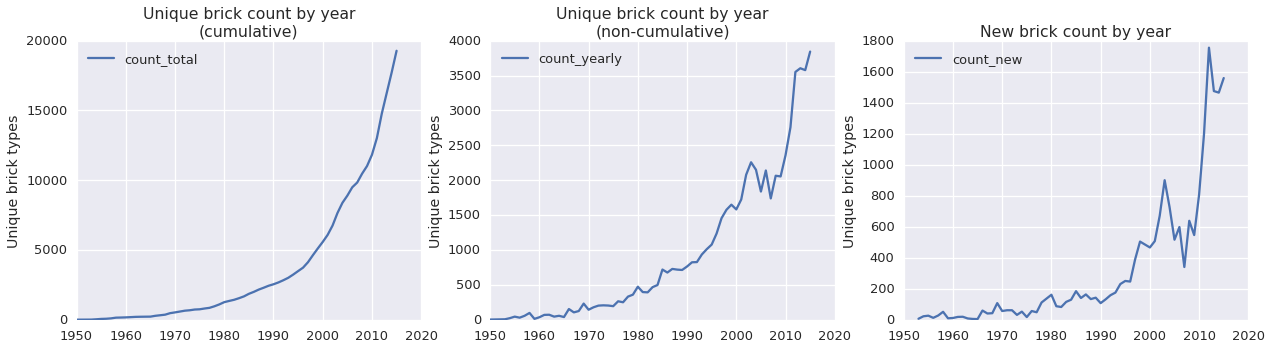

In [8]:
def plot_counts(df, fig, label=None):
    axes = fig.get_axes()
    
    assert(len(axes)==3)
    assert(df.columns.values.tolist()==['year', 'piece_list', 'count_total', 'count_yearly', 'count_new'])
    
    axes[1].plot(df.year[:-1], df.count_yearly[:-1], label=label)
    axes[1].set_title('Unique brick count by year\n(non-cumulative)');
    axes[1].set_ylabel('Unique brick types');
    axes[1].legend(loc='best')

    axes[2].plot(df.year[:-1], df.count_new[:-1], label=label)
    axes[2].set_title('New brick count by year');
    axes[2].set_ylabel('Unique brick types');
    axes[2].legend(loc='best')

    axes[0].plot(df.year[:-1], df.count_total[:-1], label=label)
    axes[0].set_title('Unique brick count by year\n(cumulative)');
    axes[0].set_ylabel('Unique brick types');
    axes[0].legend(loc='best')

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,5))
plot_counts(pieces_by_year, fig)

Right off the bat we can see that there are a lot more Lego bricks than there used to be. The 90s were my Lego heydey, and since then the number of unique brick types has more than tripled; the situation is even more dramatic if your formative Lego experiences are from the 80s. (One other interesting note about these plots: Lego almost went bankrupt in 2003, and you can see signs of the turmoil that precipitated the crises in the early 2000s and the fallout in the latter half of the decade.)

Not all bricks are created equal though: for every generally useful brick like a classic [2x4](https://rebrickable.com/parts/3001/brick-2-x-4) there's also a super-specialized brick like a '[61185c01](https://rebrickable.com/parts/61185c01)'. Or rather, there used to be; the perceived proliferation of specialized pieces is one of the major complaints behind the 'Legos aren't the creative toy they used to be' sentiment. Thanks to the data from Rebrickable we're in a position to address this impression quantitatively, so next let's investigate what types of bricks are most responsible for the increase.

The data contains category information for each brick type, however the categories as provided are a little too fine-grained to be useful. To make things a little simpler I assigned each of the 55 original categories to one of five new categories:

- Minifigures: minifigures and accessories, including plants and animals
- Basic: classic Lego bricks for general purpose building
- Specialized: bricks that are too specialized to be generally useful for creative play
- Non-brick Lego: Lego products that aren't bricks, like Bionicle or Znap
- Other: everything else

Since we're trying to address whether Lego has gotten more / too specialized over time, this mapping is actually very important; it's also necessarily subjective. Fortunately, it turns out that the trends are large enough that the specifics of the category mapping don't matter too much. Also we'll validate the 'specialized' / 'basic' assignments later by looking at how many times each brick type shows up across all Lego sets.

In [9]:
# get list of which old categories map onto each new category 
new_categories = categories.fillna(0).apply(lambda row: row.nonzero())

# make a dictionary to map the 55 old type categories onto 5 new categories
# new categories: minifig, basic, specialized, non-brick lego, other
conversion_dict = {}
for new_cat in new_categories.index.values[1:]:
    old_index_array = new_categories.ix[new_cat][0]
    for i in old_index_array.tolist():
        conversion_dict[categories.iloc[i].category] = new_cat

pieces['simple_category'] = pieces.category.map(conversion_dict)

Having assigned each brick type to one of the five simple categories, we can re-run the type counting analysis above on each subset of bricks.

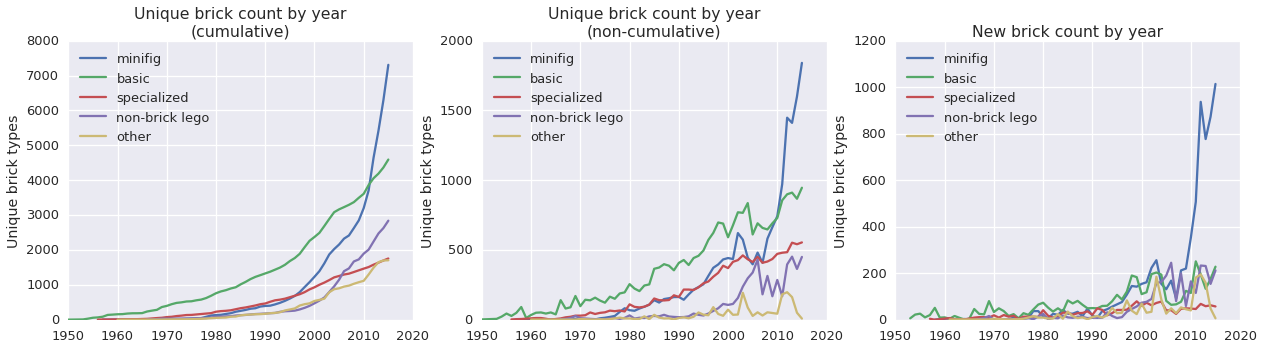

In [10]:
def count_pipeline(category, fig):
    # select the piece_ids of pieces in the category
    piece_ids = pieces.loc[pieces.simple_category==category]
    
    # filter out the pieces which aren't in that category
    raw_set_piece = set_pieces.loc[set_pieces.piece_id.isin(piece_ids.piece_id)]

    # run the pipeline
    sets_with_piece_list = get_sets_piece_list(raw_set_piece)
    pieces_by_year = get_pieces_by_year(sets_with_piece_list)
    plot_counts(pieces_by_year, fig, category)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(21,5))
category_list = ['minifig', 'basic', 'specialized', 'non-brick lego', 'other']

for category in category_list:
    count_pipeline(category, fig)

It looks like new minifigures account for a large fraction of the increase in brick types, especially since about 2010. There are definitely more minifigures than there used to be, however this also reflects the brick type labelling scheme -- remember that identical pieces with different prints count as different bricks, so each distinct minifigure counts as another new brick type. 

More to our original premise, according to the 'specialized' / 'basic' classifications we defined, overly-specific, non creative brick types are *not* proliferating faster than basic, general-purpose bricks.
This speaks to the 'How has Lego changed?' question that motivates this analysis, but the conclusion so far is still weak for two reasons: first, it depends on our subjective classification of brick types as 'specialized' or 'basic', and second, it doesn't account for how common each type of brick is. Next we'll try to make this conclusion more solid by looking at the distribution of bricks in a given year's sets.

# Yearly brick frequency distributions

The number of brick types produced in a given year is an interesting metric, but it doesn't capture much information about how suitable that year's Legos are for creative play. Who cares if a set has a handful of overly specific bricks if that same set also has tons of basic bricks? Looking at brick frequency distributions should provide a better indication of how Lego sets are changing: if Lego sets have come to rely too heavily on lots of specialized, single-use bricks then we should see the distribution of brick frequencies shift towards smaller values. Alternatively, if Lego sets contain about the same proportion of generally useful bricks as they did in the past then the distribution should look the same, just scaled up.

To calculate the brick frequency distributions we'll add up how many of each brick type each Lego set contains, and then sum over all the sets in a given year.

In [82]:
# count number of each piece_id in each set
set_piece_count = set_pieces_trimmed.groupby(['set_id','piece_id','color']).first().sum(level=[0,1])

# add a year column
set_piece_count_year = set_piece_count.join(sets_trimmed.year)

# sum piece counts over the sets in each year
sum_piece_count = set_piece_count_year.reset_index().groupby(['year','piece_id']).sum()

The brick frequncy distribution has a long tail, so we'll use logrithmic bins for the histogram.

/home/henry/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


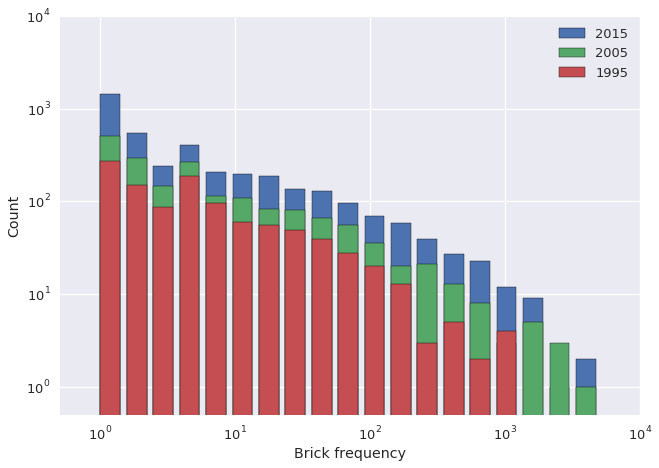

In [86]:
def plot_freq_hist(year, color):
    # distribution is long-tailed, so plot on log-log and use log-size bins
    log_bins = np.array([math.exp(x) for x in np.linspace(0,math.log(5E4),25)])
    counts, bin_edges = np.histogram(pivoted[year].dropna(),bins=log_bins)
        
    plt.bar(bin_edges[:-1], counts, width=0.4*log_bins[:-1], color= color, label=year)

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Brick frequency')
    plt.ylabel('Count')
    plt.legend()

    plt.xlim([0.5, 1E4])
    plt.ylim([0.5, 1E4])
    
# need explicit coloring bc plt.bar doesn't auto-increment color
for year, color in zip([2015,2005,1995], sns.color_palette()[:3]):
    plot_freq_hist(year, color)

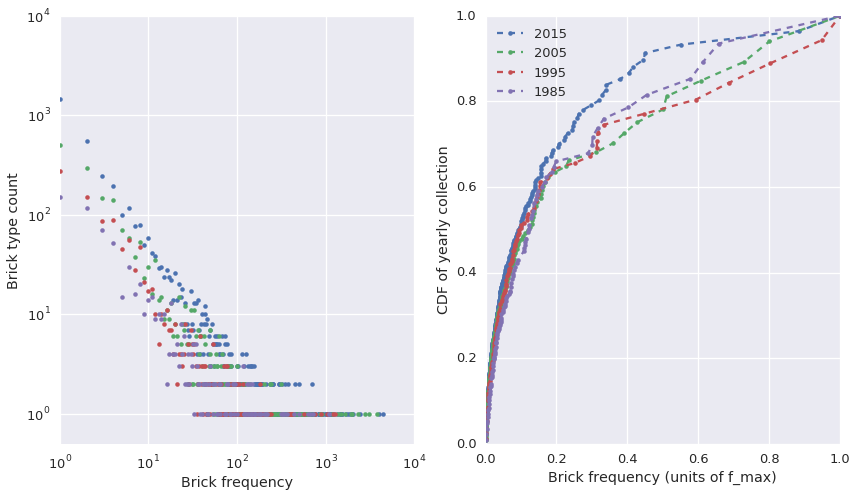

In [81]:
def plot_frequencies(year):
    df = sum_piece_count.xs(year).reset_index().groupby('num').count().reset_index()[['num','type']]
    df.columns = ['frequency','counts']
    df['sums'] = df.counts * df.frequency
    df['cum_sums'] = np.cumsum(df.sums)
    
    total = max(df.cum_sums)
    max_freq = max(df.frequency)
    
    ax1.plot(df.frequency, df.counts, '.', label=year)
    ax1.set_ylim([0.5,1E4])
    
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_xlabel('Brick frequency')
    ax1.set_ylabel('Brick type count')
    
    ax2.plot(df.frequency/max_freq, df.cum_sums/total, '.--', label=year)
    ax2.set_xlabel('Brick frequency (units of f_max)')
    ax2.set_ylabel('CDF of yearly collection')
    ax2.legend(loc='best')
    
    plt.tight_layout()
    

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))
plot_frequencies(2015)
plot_frequencies(2005)
plot_frequencies(1995)
plot_frequencies(1985)

if the graph gets twice as big, how does the power law have to change so that 

### CDF

In [84]:
# pivot the data for plotting
pivoted = sum_piece_count.reset_index().pivot(index='piece_id', columns='year', values='num')#.fillna(0)

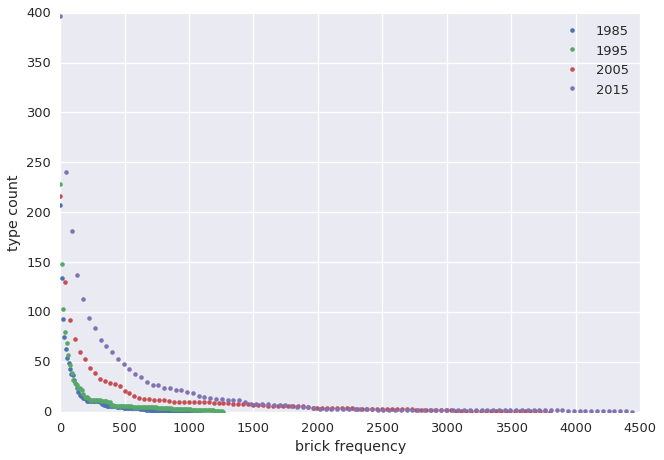

In [34]:
def plot_cdf(years):
    for yr in years:
        d = pivoted[yr].dropna().values.reshape(1,-1).transpose()
        values, base = np.histogram(d, bins=100)
        cumulative = np.cumsum(values)
        plt.plot(base[:-1], len(d)-cumulative, '.', label=yr)
        
    #plt.yscale('log')
    #plt.xscale('log')
    plt.legend(loc='best')
    plt.xlabel('brick frequency')
    plt.ylabel('type count')
            
plot_cdf([1985,1995,2005,2015])

### Zipf plot (ranked)

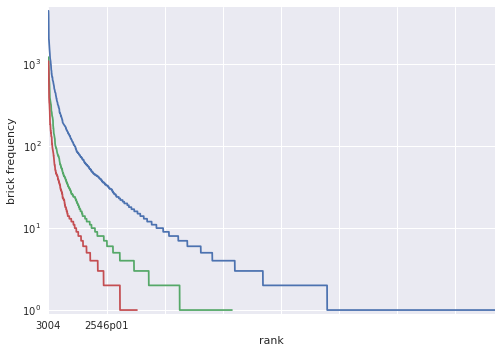

In [74]:
pivoted[2015].dropna().sort_values(ascending=False).plot()
pivoted[2000].dropna().sort_values(ascending=False).plot()
pivoted[1990].dropna().sort_values(ascending=False).plot()

plt.gca().set_yscale('log')
plt.gca().set_ylim([0.9,0.5E4])

plt.xlabel('rank');
plt.ylabel('brick frequency');

In [25]:
# normalize by number of pieces and number of types (x and y axes)

# maybe replace with numpy function
def norm(x):
    return x / np.max(x)

norm_pivoted = pivoted.apply(norm)

(0.00022396416573348266, 1)

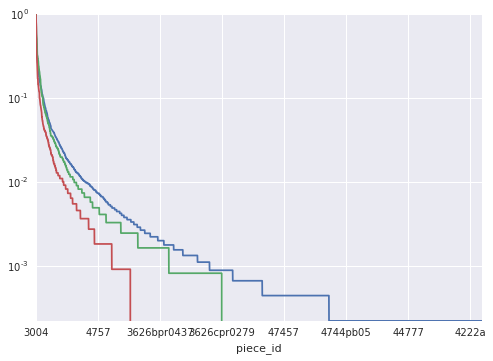

In [86]:
norm_pivoted[2015].sort_values(ascending=False).iloc[:3600].plot()

norm_pivoted[2000].sort_values(ascending=False).iloc[:3600].plot()

norm_pivoted[1990].sort_values(ascending=False).iloc[:3600].plot()

plt.gca().set_yscale('log')
plt.gca().set_ylim([0,1])

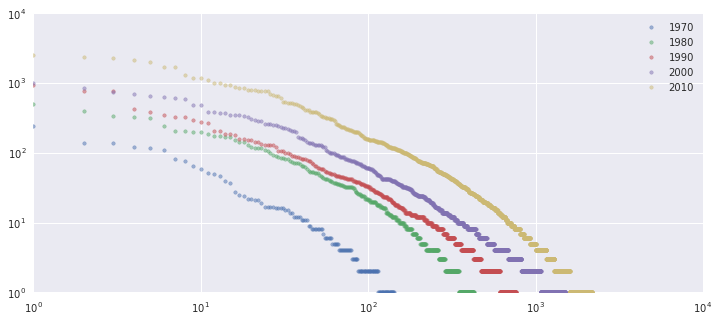

In [107]:
def plot_loglog(yr_list):
    fig, ax = plt.subplots(1,1, figsize=(12,5))

    for yr in yr_list:
        df = pivoted[yr].dropna().sort_values(ascending=False)
        xs = df.reset_index().index.values
        ys = df.values
        ax.plot(xs,ys, '.', label=yr, alpha=0.5)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    
plot_loglog([1970, 1980, 1990, 2000, 2010])

# H-index for sets

At this point we have a broad understanding of how the 

H-index = number of pieces shared with number of sets

Define a metric which measures the overlap of a given Lego set with the rest of Lego. the largest number *L* for which there are *L* other sets which contain at least *L* of the same brick types.  

There are a number of ways to improve this:

- when calculating *L* for a given Lego set, only consider overlap with Lego sets released before that set.
- account for the fact that Lego sets with lots of brick types will naturally have higher *L*

In [173]:
sets_with_types_h.loc[sets_with_types_h.year==2016].sort_values('h_ratio')

NameError: name 'sets_with_types_h' is not defined

In [187]:
def compare_all_sets(pieces_str):
    pieces_set = set(pieces_str.split())
    return sets_with_piece_list.piece_list.apply(lambda set_list: len(pieces_set & set(set_list.split())))

In [190]:
# takes ~20 min
overlap_matrix = sets_with_piece_list.piece_list.apply(compare_all_sets)

In [197]:
def overlap_by_ids(id_a, id_b):
    set_a = str_to_set(sets_with_piece_list.ix[id_a].piece_list)
    set_b = str_to_set(sets_with_piece_list.ix[id_b].piece_list)
    
    print('{} piece_ids ({:3d}): {}'.format(id_a, len(set_a), str(set_a)))
    print('{} piece_ids ({:3d}): {}'.format(id_b, len(set_b), str(set_b)))
    print('overlap: {}'.format(str(set_a & set_b)))
    
overlap_by_ids('0012-1','WishingWell-1')

0012-1 piece_ids (  6): {'3626apr0001', '3962a', '973p90c02', '3838', '3842a', '970c00'}
WishingWell-1 piece_ids (  9): {'85984', '3794b', '85080', '3069b', '33291', '3021', '3710', '3032', '3062b'}
overlap: set()


In [199]:
# set the diagonal entries to zero
np.fill_diagonal(overlap_matrix.values, 0)

In [279]:
def calc_h(set_id):
    overlap_cts = overlap_matrix[set_id]
    grouped_cts = overlap_cts.reset_index().groupby(set_id).count().reset_index()
    grouped_cts.columns = ['num_types_overlapping', 'num_sets']
    
    grouped_cts['cum_num_sets'] = np.cumsum(grouped_cts.num_sets[::-1])
    
    mask = grouped_cts.cum_num_sets > grouped_cts.num_types_overlapping
    h = grouped_cts.loc[mask].tail(1).num_types_overlapping.values[0]
    
    return h

In [281]:
tmp_dict = {}

for set_id in overlap_matrix.index.values:
    tmp_dict[set_id] = calc_h(set_id)

h_factors = pd.Series(tmp_dict, name='h')

In [282]:
sets_with_types_h = sets_with_types.join(h_factors)
sets_with_types_h.head()

,year,pieces,t1,descr,num,type,h
00-1,1970,471,Legoland,Weetabix Castle,471,26,17
00-2,1976,147,Legoland,Weetabix Promotional House 1,147,38,19
00-3,1976,149,Legoland,Weetabix Promotional House 2,149,31,19
00-4,1976,126,Legoland,Weetabix Promotional Windmill,126,39,21
0011-2,1978,12,Town,Town Mini-Figures,12,8,6


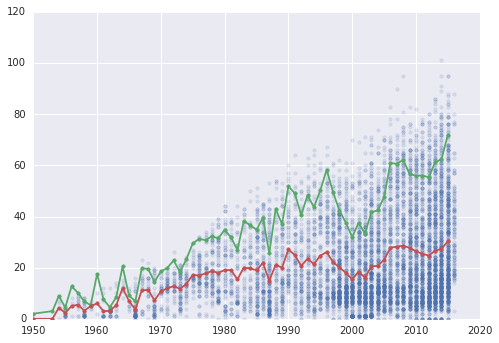

In [283]:
plt.plot(sets_with_types_h.year, sets_with_types_h.h, '.', alpha=0.15)
plt.plot(np.sort(sets_with_types_h.year.unique())[:-1], sets_with_types_h.groupby('year').mean().type[:-1], '.-')
plt.plot(np.sort(sets_with_types_h.year.unique())[:-1], sets_with_types_h.groupby('year').mean().h[:-1], '.-')

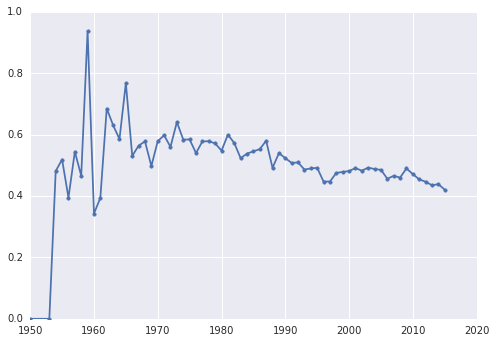

In [304]:
plt.plot(np.sort(sets_with_types_h.year.unique())[:-1], \
         sets_with_types_h.groupby('year').mean().h[:-1]/sets_with_types_h.groupby('year').mean().type[:-1], '.-')

In [284]:
df = sets_with_types_h
df['h_ratio'] = df.h/df.type
df.groupby('t1').mean().sort_values('h_ratio').index.values

array(['Collectible Minifigures', "Disney's Mickey Mouse", 'Clikits',
       '4 Juniors', 'Belville', 'Duplo', 'The Lone Ranger',
       'Pirates of the Caribbean', 'Dino', 'Avatar', 'Vikings', 'Agents',
       'Juniors', 'Time Cruisers', 'Scooby-Doo', 'Ninjago', 'Hero Factory',
       'Minitalia', 'Indiana Jones', 'Aquazone', 'Jurassic World',
       'Monster Fighters', 'Power Miners', 'Fabuland', 'Legends of Chima',
       'Teenage Mutant Ninja Turtles', 'Western', 'The LEGO Movie',
       'Alpha Team', 'Elves', "Pharaoh's Quest",
       'The Hobbit and Lord of the Rings', 'Rock Raiders', 'Nexo Knights',
       'Island Xtreme Stunts', 'Super Heroes', 'SpongeBob SquarePants',
       'Disney Princess', 'Harry Potter', 'Ninja', 'Atlantis', 'Sports',
       'Prince of Persia', 'Exo-Force', 'Dimensions', 'Ben 10',
       'Speed Champions', 'Mindstorms', 'Master Building Academy',
       'Castle', 'Gear', 'Adventurers', 'Pirates', 'Cars', 'Dino 2010',
       'LEGO Ideas and CUUSOO', 'Hobby

In [288]:
a = overlap_matrix['8409-1'].loc[overlap_matrix['8409-1']>0].reset_index().groupby('8409-1').count()
a

,set_id
8409-1,
1,22
4,2
5,2
6,1


In [289]:
np.cumsum(a[::-1])

,set_id
8409-1,
6,1
5,3
4,5
1,27


# Graph analysis

In [306]:
import networkx as nx

In [ ]:
graph = nx.from_numpy_matrix(overlap_matrix.as_matrix())

# Log #pieces vs Log #piece types, by set theme

In [5]:
num_themes = len(sets_trimmed.t1.unique())

In [234]:
# dictionary which describes how to aggregate each column
agg_dict = {'num': np.sum, 'type': lambda x: 1}

# counts same piece in diff. color as same type
pieces_by_set = set_pieces_trimmed.groupby(['set_id','piece_id']).agg(agg_dict).sum(level=[0])

In [235]:
pieces_by_set.head()

,num,type
set_id,,
00-1,471,26
00-2,147,38
00-3,149,31
00-4,126,39
0011-2,12,8


In [236]:
sets_trimmed.head()

,year,pieces,t1,descr
set_id,,,,
00-1,1970,471,Legoland,Weetabix Castle
0011-2,1978,12,Town,Town Mini-Figures
0012-1,1979,12,Space,Space Mini-Figures
0013-1,1979,12,Space,Space Mini-Figures
0014-1,1979,12,Space,Space Mini-Figures


In [237]:
sets_with_types = pd.concat([sets_trimmed,pieces_by_set], axis=1)
sets_with_types.head()

,year,pieces,t1,descr,num,type
00-1,1970,471,Legoland,Weetabix Castle,471,26
00-2,1976,147,Legoland,Weetabix Promotional House 1,147,38
00-3,1976,149,Legoland,Weetabix Promotional House 2,149,31
00-4,1976,126,Legoland,Weetabix Promotional Windmill,126,39
0011-2,1978,12,Town,Town Mini-Figures,12,8


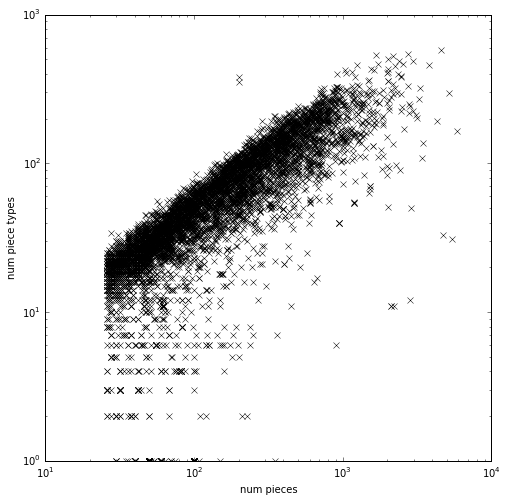

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(sets_with_types.pieces, sets_with_types.type, 'kx')

ax.set_xlabel('num pieces')
ax.set_ylabel('num piece types')

ax.set_xscale('log')
ax.set_yscale('log')

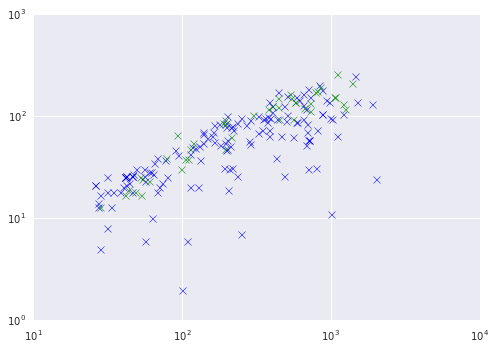

In [84]:
df = df_nonlicensed#sets_with_types.reset_index().groupby(['year','index']).first()

def plotyr(year):
    #for year in df.index.get_level_values(0).unique()[year]:
    plt.plot(df.xs(year).pieces, df.xs(year).type, 'bx')
    
    try:
        plt.plot(df_licensed.xs(year).pieces, df_licensed.xs(year).type, 'gx')
    except:
        print('nope')
        pass

    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    
widgets.interact(plotyr, year=(1956,2016,1))

In [8]:
sets_types_by_year = sets_with_types.reset_index().groupby(['year','index']).first()

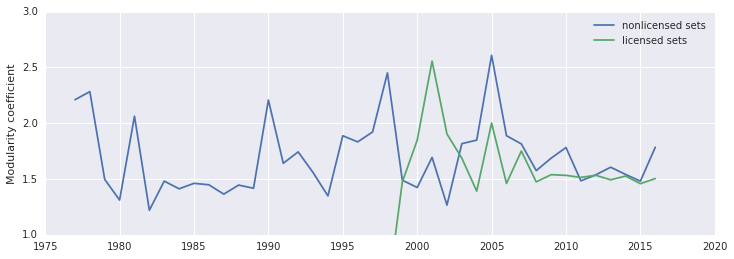

In [9]:
# see "Scaling of Differentiation in Networks ..." paper 
# http://www.uvm.edu/~pdodds/teaching/courses/2009-08UVM-300/docs/others/everything/changizi2002a.pdf
df = sets_types_by_year
df['log_num'] = df.num.apply(np.log)
df['log_type'] = df.type.apply(np.log)

# separate licensed and non_licensed sets
df_licensed = df[df.t1.isin(licensed_t1)]
df_nonlicensed = df[~df.t1.isin(licensed_t1)]

years = df.index.get_level_values('year').unique()[-40:]
    
mod_coefs_licensed = []
mod_coefs_nonlicensed = []

for yr in years:
    # fit log(num_parts) vs log(num_types) for licensed and non-licensed sets
    c_nonlicensed = 1 / np.polyfit(df_nonlicensed.xs(yr).log_num, df_nonlicensed.xs(yr).log_type, 1)[0]  
    
    # for years without any licensed sets, c_licensed = 0
    try:
        c_licensed = 1 / np.polyfit(df_licensed.xs(yr).log_num, df_licensed.xs(yr).log_type, 1)[0]
    except TypeError:
        c_licensed = 0
        
    mod_coefs_licensed.append(c_licensed)
    mod_coefs_nonlicensed.append(c_nonlicensed)

plt.figure(figsize=(12,4))
plt.plot(years, mod_coefs_nonlicensed, label='nonlicensed sets')
plt.plot(years, mod_coefs_licensed, label='licensed sets')
plt.gca().set_ylim([1,3])
plt.ylabel('Modularity coefficient');
plt.legend();

In [437]:
yr = 1980
np.polyfit(df.xs(yr).log_num, df.xs(yr).log_type, 1)

array([ 0.87989042, -0.63892512])

# Vectorizing sets

# Distributions of how many sets each piece is in (normalized)

In [94]:
pieces_sets_containing = set_pieces.groupby('piece_id').agg({'set_id': lambda x: set(' '.join(x).split())})
pieces_sets_containing.columns = ['set_list']
pieces_sets_containing.head()

,set_list
piece_id,
00-2,{00-7}
00-3,{00-7}
00-4,{00-7}
0687b1,{970687-1}
0901,{080-1}


In [88]:
yearly_sets = sets.groupby('year').agg({'set_id': lambda x: set(' '.join(x).split())})
yearly_sets.columns = ['set_list_yr']

In [89]:
yearly_sets.head()

,set_list_yr
year,
1950,"{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700..."
1953,"{700.3.4-1, 700.B-1, 700.1.4-1, 700.F-1}"
1954,"{700.C.3-1, 700.28-1, 700.16-1, 700.C.1-1, 700..."
1955,"{1217-2, 1210-2, b55dk-01, 1247-2, 1224-2, 122..."
1956,"{1310-1, 224-1, 1271-2, 1231-3, b56de-01, 231-..."


need one df with

    index
    year  piece1   set(list of sets containing piece1)
          piece2   set(list of sets containing piece2)
          etc
          
and one df with

    index
    year1   set(list of sets)
    year2   set(list of sets)
    
then for each row of first df take intersection of piece sets and year sets, take len, divide by len of year set

In [241]:
set_pieces.head()

,set_id,piece_id,num,color,type
0,10228-1,61252,1,72,1
1,853340-1,3741,1,2,1
2,853340-1,2343,1,47,1
3,8458-1-b1,32062,52,0,1
4,853340-1,3035,1,15,1


In [91]:
sets_years = sets[['year','set_id']]

In [92]:
yearly_pieces = set_pieces.merge(sets_years, on ='set_id').groupby(['year','piece_id']).first()
yearly_pieces.head()

set_id  num  color  type
year piece_id                              
1950 bdoor01    700.B.4-1    1      4     1
     bslot02      700.A-1    3     15     1
     bslot04      700.A-1    3     10     1
     bwindow01  700.B.3-1    1      4     1
     bwindow02  700.B.2-1    1      4     1

In [95]:
with_sets = yearly_pieces.join(pieces_sets_containing, how='left').reset_index()

with_sets.head()

,year,piece_id,set_id,num,color,type,set_list
0,1950,bdoor01,700.B.4-1,1,4,1,"{700.B.4-1, 700.B-1}"
1,1950,bslot02,700.A-1,3,15,1,"{700.1.2-1, 700.A-1}"
2,1950,bslot04,700.A-1,3,10,1,"{700.A-1, 700.1.1-1}"
3,1950,bwindow01,700.B.3-1,1,4,1,"{700.B-1, 700.B.3-1}"
4,1950,bwindow02,700.B.2-1,1,4,1,"{700.B-1, 700.B.2-1}"


In [96]:
with_sets = with_sets.merge(yearly_sets.reset_index(), on='year')

with_sets.head()

,year,piece_id,set_id,num,color,type,set_list,set_list_yr
0,1950,bdoor01,700.B.4-1,1,4,1,"{700.B.4-1, 700.B-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700..."
1,1950,bslot02,700.A-1,3,15,1,"{700.1.2-1, 700.A-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700..."
2,1950,bslot04,700.A-1,3,10,1,"{700.A-1, 700.1.1-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700..."
3,1950,bwindow01,700.B.3-1,1,4,1,"{700.B-1, 700.B.3-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700..."
4,1950,bwindow02,700.B.2-1,1,4,1,"{700.B-1, 700.B.2-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700..."


In [98]:
# references on yearly_sets df
def inter_len(row, count=False):
    
    year_set = yearly_sets.ix[row.year]['set_list_yr']
    piece_set = row['set_list']
    
    if count:
        return 1.0 * len(year_set.intersection(piece_set))
    else:
        return 1.0 * len(year_set.intersection(piece_set)) / len(year_set)            

with_sets['overlap_pct'] = with_sets.apply(lambda row: inter_len(row), axis=1)
with_sets['overlap_ct'] = with_sets.apply(lambda row: inter_len(row, True), axis=1)
with_sets.head()

,year,piece_id,set_id,num,color,type,set_list,set_list_yr,overlap_pct,overlap_ct
0,1950,bdoor01,700.B.4-1,1,4,1,"{700.B.4-1, 700.B-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700...",0.142857,1
1,1950,bslot02,700.A-1,3,15,1,"{700.1.2-1, 700.A-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700...",0.285714,2
2,1950,bslot04,700.A-1,3,10,1,"{700.A-1, 700.1.1-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700...",0.285714,2
3,1950,bwindow01,700.B.3-1,1,4,1,"{700.B-1, 700.B.3-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700...",0.142857,1
4,1950,bwindow02,700.B.2-1,1,4,1,"{700.B-1, 700.B.2-1}","{700.1.2-1, 700.B.4-1, 700.A-1, 700.B.1-1, 700...",0.142857,1


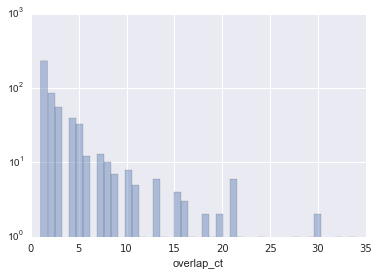

In [389]:
def plot_dist(yr):
    sns.distplot(with_sets.groupby(['year','piece_id']).first().xs(yr).overlap_ct, norm_hist=False, kde=False)
    plt.gca().set_yscale('log')
    
widgets.interact(plot_dist, yr=(1970,2015,1))

fit an exponential, see how fitted parameter changes over time

In [99]:
singles_by_yr = with_sets.groupby(['year','piece_id']).agg({'overlap_ct': lambda x: x==1}).sum(level=0).reset_index()

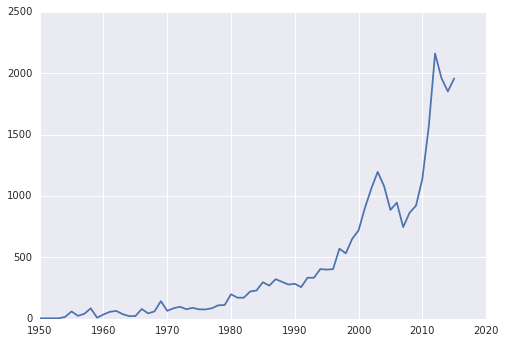

In [100]:
plt.plot(singles_by_yr.year[:-1], singles_by_yr.overlap_ct[:-1])

In [22]:
np.sort(sets.t1.unique())

array(['4 Juniors', 'Adventurers', 'Agents', 'Alpha Team', 'Aquazone',
       'Architecture', 'Atlantis', 'Avatar', 'Belville', 'Ben 10',
       'Bionicle', 'Boat', 'Books', 'Building Set with People',
       'Bulk Bricks', 'Cars', 'Castle', 'Classic', 'Clikits',
       'Collectible Minifigures', 'Creator', 'Designer Sets', 'Dimensions',
       'Dino', 'Dino 2010', 'Dino Attack', 'Dinosaurs', 'Discovery',
       'Disney Princess', "Disney's Mickey Mouse", 'Duplo',
       'Educational and Dacta', 'Elves', 'Exo-Force', 'FIRST LEGO League',
       'Fabuland', 'Factory', 'Freestyle', 'Friends', 'Fusion', 'Gear',
       'Harry Potter', 'Hero Factory', 'Hobby Sets', 'Homemaker',
       'Indiana Jones', 'Inventor', 'Island Xtreme Stunts', 'Juniors',
       'Jurassic World', 'LEGO Brand Store', 'LEGO Ideas and CUUSOO',
       'Legends of Chima', 'Legoland', 'Legoland Parks',
       'Master Building Academy', 'Mindstorms', 'Minecraft', 'Minitalia',
       'Mixels', 'Model Team', 'Modular Buildi

# Bibliography

[reddit post by designer](https://www.reddit.com/r/lego/comments/1x6ldp/lego_franchise_infographic/cf8vdl3)